In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
np.random.seed(42)

In [3]:
#read the input drug-metabolite data
data = pd.read_csv('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\data\\Tolylquinone_metabolic_NCI.csv')
data.head(2)

,Cell Line,Acetone ; Propanal ; acetone,Acetaldehyde oxime ; HMDB01122,acetate,Urea,Isopropyl alcohol ; Propyl alcohol,Bicarbonate ; Hydrogen carbonate,Dimethylsulfide,3-Butyn-1-al,1-pyrrolinium,...,O-b-D-glucopyranosyl-(1->3)-O-2-(acetylamino)-2-deoxy-b-D-glucopyranosyl-(1->3)-O-[6-deoxy-a-L-galactopyranosyl-(1->4)]-O-b-D-galactopyranosyl-(1->4)-O-[6-deoxy-a-L-galactopyranosyl-(1->3)]-D-Glucose,LS tetrasaccharide d ; Sialyllacto-N-neotetraose c ; Sialyllacto-N-tetraose a ; Sialyllacto-N-tetraose b ; Sialyllacto-N-tetraose c,PIP2(16:0/18:0) ; PIP2(18:0/16:0),"TG(22:5(7Z,10Z,13Z,16Z,19Z)/20:5(5Z,8Z,11Z,14Z,17Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))[iso6] ; TG(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/20:4(5Z,8Z,11Z,14Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))[iso3]","(2E)-Hexadecenoyl-CoA ; 2,7,10-hexadecatrienoylcoa ; 3,7,10-hexadecatrienoylcoa ; 3Z,7Z,10Z-hexadecatrienoyl-CoA ; 4,7,10-hexadecatrienoylcoa ; 4Z,7Z,10Z-hexadecatrienoyl-CoA ; 7,10,13-hexadecatrienoylcoa ; trans,cis,cis-2,7,10-hexadecatrienoyl-CoA",Lacto-N-difucohexaose ; Lacto-N-difucopentaose II,Galabiosylceramide (d18:1/26:1(17Z)) ; Lactosylceramide (d18:1/26:1(17Z)),cells,Cell names,tolylquinone
0,Breast_BT549,0.021811,0.006137,1.801231,0.178675,0.031762,0.143416,0.004437,0.001118,0.002353,...,0.036367,0.025836,0.075427,0.036502,0.019935,0.032820,0.039391,BT549,BR:BT-549,4.813333
1,Breast_HS578T,0.010611,0.006815,0.884542,0.093390,0.016027,0.037372,NaN,0.005778,0.003199,...,0.024981,0.013982,0.054200,0.029125,0.010750,0.015981,0.035154,HS578T,BR:HS 578T,4.683333


In [4]:
#drop the target drug column
drug = data.pop('tolylquinone')

In [5]:
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\ModelRunNTimes\\outputs\\representative_metabolites.txt', 'r+') as f:
    rep_meta = f.read().strip().splitlines()

In [6]:
#select the input features, drop all metadata
X = data.select_dtypes('float64')

#select only the representative metabolites
X = X[rep_meta]

#fill the NaNs with mean of each column
X.fillna(X.mean(), inplace=True)

In [7]:
X.shape

(52, 197)

In [8]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

In [9]:
#create empty list to store labels and take mean of the response values
#if response value is greater than mean then store 'NR' else store 'R'
#convert the list of labels into a Series

target, drug_mean = [], drug.mean()
for i in drug:
    if i > drug_mean:
        target.append('NR')
    else:
        target.append('R')
y = pd.Series(target)

In [10]:
X.shape, y.shape

((52, 197), (52,))

In [11]:
#initialize the LabelEncoder instance
le = LabelEncoder()

#encode the labels into 0 and 1 for NR and R respectively
y = pd.Series(le.fit_transform(y))
y.value_counts()

1    33
0    19
dtype: int64

In [12]:
#initialize SMOTE instance
smote = SMOTE()

#use SMOTE to create synthetic samples to create a balanced set of data
X, y = smote.fit_resample(X, y)

In [13]:
#initialize StandardScaler for normalization of input features
scaler = StandardScaler()

#normalize the input dataframe
X = pd.DataFrame(data = scaler.fit_transform(X), columns = X.columns)
X.head(2)

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Theaflavin-3-gallate,"PC(14:0/18:4(6Z,9Z,12Z,15Z)) ; PC(14:1(9Z)/18:3(6Z,9Z,12Z)) ; PC(14:1(9Z)/18:3(9Z,12Z,15Z)) ; PC(18:3(6Z,9Z,12Z)/14:1(9Z)) ; PC(18:3(9Z,12Z,15Z)/14:1(9Z)) ; PC(18:4(6Z,9Z,12Z,15Z)/14:0) ; PE(15:0/20:4(5Z,8Z,11Z,14Z)) ; PE(15:0/20:4(8Z,11Z,14Z,17Z)) ; PE(20:4(5Z,8Z,11Z,14Z)/15:0) ; PE(20:4(8Z,11Z,14Z,17Z)/15:0)",Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8
0,1.390409,-0.182141,-0.811786,-0.765147,0.029913,-0.612727,0.124319,-0.552508,-0.530870,0.775370,...,-1.158384,-0.985702,-0.461933,-1.094357,0.653418,-1.234583,-0.509826,0.241904,-0.762527,1.115589
1,-0.321756,0.543561,-0.455019,-0.117538,0.572570,-0.319685,-1.133246,-1.130814,-1.177038,1.330105,...,-0.754713,-0.158764,-1.207082,0.049877,-0.936599,-1.094391,-1.158803,-2.154093,-1.588911,0.735736


In [14]:
X.shape, y.shape

((66, 197), (66,))

In [15]:
y.value_counts()

0    33
1    33
dtype: int64

In [16]:
X.shape

(66, 197)

In [17]:
X.head(2)

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Theaflavin-3-gallate,"PC(14:0/18:4(6Z,9Z,12Z,15Z)) ; PC(14:1(9Z)/18:3(6Z,9Z,12Z)) ; PC(14:1(9Z)/18:3(9Z,12Z,15Z)) ; PC(18:3(6Z,9Z,12Z)/14:1(9Z)) ; PC(18:3(9Z,12Z,15Z)/14:1(9Z)) ; PC(18:4(6Z,9Z,12Z,15Z)/14:0) ; PE(15:0/20:4(5Z,8Z,11Z,14Z)) ; PE(15:0/20:4(8Z,11Z,14Z,17Z)) ; PE(20:4(5Z,8Z,11Z,14Z)/15:0) ; PE(20:4(8Z,11Z,14Z,17Z)/15:0)",Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8
0,1.390409,-0.182141,-0.811786,-0.765147,0.029913,-0.612727,0.124319,-0.552508,-0.530870,0.775370,...,-1.158384,-0.985702,-0.461933,-1.094357,0.653418,-1.234583,-0.509826,0.241904,-0.762527,1.115589
1,-0.321756,0.543561,-0.455019,-0.117538,0.572570,-0.319685,-1.133246,-1.130814,-1.177038,1.330105,...,-0.754713,-0.158764,-1.207082,0.049877,-0.936599,-1.094391,-1.158803,-2.154093,-1.588911,0.735736


In [18]:
#find the indices of the input dataset
indices = X.index.values

#split the dataset into train and test datasets
X_train, X_test, train_index, test_index = train_test_split(X, indices, test_size = 0.20, random_state = 43)
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [19]:
X_train.shape, X_test.shape

((52, 197), (14, 197))

In [20]:
y_train.value_counts(), y_test.value_counts()

(0    26
 1    26
 dtype: int64,
 1    7
 0    7
 dtype: int64)

In [21]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction = []

#define a list to store the number of features being selected each run
num_features = []

#define the model
model = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced')

#define a list to store accuracy, precision and recall 
acc_score, rec_score, pre_score = [], [], []


#run the feature selection and model training and evaluation N times
for i in range(N): 
    #define base estimator for feature selection and fit the training data to it
    base_estimator = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SelectFromModel to select features based on base estimator provided and use the mean of the feature importances
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train and test data using SFM
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X.columns[sfm.get_support(1)])
    
    print(f'Number of features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features.append(len(X_train.columns))
    
    #define the machine learning model and train it
    model.fit(X_train_new, y_train)
    
    #make predictions and other metrics
    y_pred = model.predict(X_test_new)
    acc_score.append(accuracy_score(y_test, y_pred))
    rec_score.append(recall_score(y_test, y_pred, pos_label=1))
    pre_score.append(precision_score(y_test, y_pred, pos_label=1))
    
    #store the probabilites of each run
    prediction.append(model.predict_proba(X_test_new))

    
acc_score = np.array(acc_score)
rec_score = np.array(rec_score)
pre_score = np.array(pre_score)
print(f'Accuracy score: {np.mean(acc_score)}, Standard deviation: {np.std(acc_score)}')
print(f'Recall score: {np.mean(rec_score)}, Standard deviation: {np.std(rec_score)}')
print(f'Precision score: {np.mean(pre_score)}, Standard deviation: {np.std(pre_score)}')

#indice = np.unique(np.array(indice))
prediction = np.array(prediction)
prediction = np.mean(prediction, axis=0)[:, 1]

Number of features selected during iteration 0: 63
Number of features selected during iteration 1: 70
Number of features selected during iteration 2: 57
Number of features selected during iteration 3: 57
Number of features selected during iteration 4: 63
Number of features selected during iteration 5: 67
Number of features selected during iteration 6: 60
Number of features selected during iteration 7: 66
Number of features selected during iteration 8: 59
Number of features selected during iteration 9: 60
Number of features selected during iteration 10: 65
Number of features selected during iteration 11: 69
Number of features selected during iteration 12: 52
Number of features selected during iteration 13: 63
Number of features selected during iteration 14: 65
Number of features selected during iteration 15: 58
Number of features selected during iteration 16: 66
Number of features selected during iteration 17: 60
Number of features selected during iteration 18: 66
Number of features sel

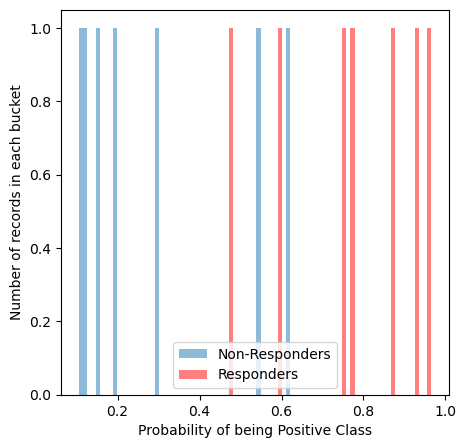

In [22]:
plt.figure(figsize=(5, 5))
plt.hist(prediction[y_test==0], label='Non-Responders', alpha = 0.5, bins = 50)
plt.hist(prediction[y_test==1], label='Responders', alpha=0.5, bins = 50, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [23]:
df_rf_test = X_test.copy()
df_rf_test.loc[test_index, 'test_proba'] = prediction
df_rf_test.loc[test_index, 'target'] = y
df1 = pd.concat([X_train, df_rf_test], sort=False).sort_index()

In [24]:
df1

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,1.390409,-0.182141,-0.811786,-0.765147,0.029913,-0.612727,0.124319,-0.552508,-0.530870,0.775370,...,-0.461933,-1.094357,0.653418,-1.234583,-0.509826,0.241904,-0.762527,1.115589,NaN,NaN
1,-0.321756,0.543561,-0.455019,-0.117538,0.572570,-0.319685,-1.133246,-1.130814,-1.177038,1.330105,...,-1.207082,0.049877,-0.936599,-1.094391,-1.158803,-2.154093,-1.588911,0.735736,NaN,NaN
2,0.881798,0.865537,-1.110763,-0.393559,0.517477,-0.730662,0.630355,0.551579,0.506838,-0.578824,...,-0.014144,-0.956000,-0.226063,-1.120271,-0.376728,-0.605035,-0.654898,-0.237836,NaN,NaN
3,-1.459050,-1.420171,0.899141,0.918588,1.105902,-0.504669,0.212440,1.522195,1.615133,-0.693285,...,-0.188425,-0.241901,0.209203,0.194145,-0.461493,-0.874633,0.433793,-0.835934,NaN,NaN
4,-1.483121,-0.057328,-0.468390,0.384379,-1.429830,-0.726266,-0.830185,-0.284303,-0.639492,-0.833595,...,-1.296961,0.298429,-1.591355,1.115319,-2.026658,-0.716160,-1.140054,-0.085691,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,0.738681,0.946810,0.130910,-0.222658,1.081287,1.048804,1.023083,0.623967,0.791437,-0.430964,...,0.483690,-0.536175,1.188293,1.131270,1.184831,0.968577,0.847409,0.232832,NaN,NaN
62,-0.517996,-0.301751,-0.733016,-0.450204,-0.084127,-0.639893,-0.540391,0.111873,0.128355,0.014643,...,0.696999,0.141135,-0.038386,-0.739822,0.018008,0.219243,0.237295,-0.438200,NaN,NaN
63,-0.183622,0.528172,0.659662,-0.122240,1.769567,-0.105774,0.957036,1.882152,1.685052,0.040208,...,2.142045,1.286565,2.231737,0.044786,1.959843,1.952841,2.449337,0.584694,NaN,NaN
64,1.470084,-1.698338,-1.200183,-0.875006,0.117897,-1.161587,0.102741,0.368464,0.554505,-1.220502,...,-0.113336,-1.017742,-0.418034,-1.082946,-0.419362,-0.168677,-0.549625,0.767915,NaN,NaN


In [25]:
df1_main = df1.iloc[:51, ]
x = max(prediction[y_test == 0])
df1_main = df1_main.loc[(df1_main['test_proba'] > x)]
df1_main.shape

(5, 199)

In [26]:
df1_main.index.values #0 40 41 42

array([ 5, 18, 22, 33, 40], dtype=int64)

In [27]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction2 = []

#define a list to store the number of features selected in each iteration
num_features2 = []

#define a list to store accuracy, precision and recall 
model2 = SVC(C=1, gamma=1, probability=True)
acc_score2, rec_score2, pre_score2 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define the base estimator for feature selection
    base_estimator = RandomForestClassifier(n_estimators=150, class_weight='balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute the importances of each feature
    importances = base_estimator.feature_importances_
    
    #use SelectFromModel and mean importances to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train-test data using important features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_train.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features2.append(len(X_train_new.columns))

    #define the SVM model and train it
    model2.fit(X_train_new, y_train)
    
    #comput predictions
    y_pred2 = model2.predict(X_test_new)
    acc_score2.append(accuracy_score(y_test, y_pred2))
    rec_score2.append(recall_score(y_test, y_pred2, pos_label=1))
    pre_score2.append(precision_score(y_test, y_pred2, pos_label=1))
    prediction2.append(model2.predict_proba(X_test_new))


acc_score2 = np.array(acc_score2)
rec_score2 = np.array(rec_score2)
pre_score2 = np.array(pre_score2)
print(f'Accuracy score: {np.mean(acc_score2)}, Standard deviation: {np.std(acc_score2)}')
print(f'Recall score: {np.mean(rec_score2)}, Standard deviation: {np.std(rec_score2)}')
print(f'Precision score: {np.mean(pre_score2)}, Standard deviation: {np.std(pre_score2)}')


prediction2 = np.array(prediction2)
prediction2 = np.mean(prediction2, axis=0)[:, 1]

Features selected during iteration 0: 60
Features selected during iteration 1: 59
Features selected during iteration 2: 63
Features selected during iteration 3: 66
Features selected during iteration 4: 61
Features selected during iteration 5: 63
Features selected during iteration 6: 57
Features selected during iteration 7: 53
Features selected during iteration 8: 58
Features selected during iteration 9: 67
Features selected during iteration 10: 71
Features selected during iteration 11: 62
Features selected during iteration 12: 64
Features selected during iteration 13: 67
Features selected during iteration 14: 57
Features selected during iteration 15: 59
Features selected during iteration 16: 60
Features selected during iteration 17: 64
Features selected during iteration 18: 66
Features selected during iteration 19: 60
Features selected during iteration 20: 71
Features selected during iteration 21: 58
Features selected during iteration 22: 62
Features selected during iteration 23: 57
Fe

In [28]:
print(f'Average number of features being selected: {np.mean(num_features2)}')

Average number of features being selected: 62.56


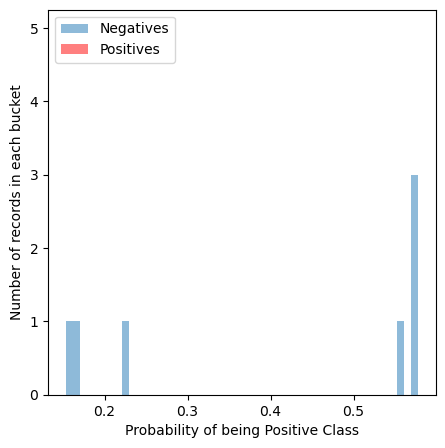

In [29]:
plt.figure(figsize=(5,5))
plt.hist(prediction2[y_test==0], label='Negatives', alpha = 0.5, bins = 50)
plt.hist(prediction2[y_test==1], label='Positives', alpha=0.5, bins = 50, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [30]:
df_svm_test = X_test.copy()
df_svm_test.loc[test_index, 'test_proba'] = prediction2
df_svm_test.loc[test_index, 'target'] = y_test
df2 = pd.concat([X_train, df_svm_test], sort=False).sort_index()

In [31]:
df2_main = df2.iloc[:51, ]
df2_main = df2_main.loc[(df2_main['test_proba'] > max(prediction2[y_test == 0]))]
df2_main

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
14,0.394437,-0.233167,1.135710,0.521580,-0.865127,1.140121,0.550898,-0.924736,-1.131072,-1.864461,...,-0.122292,0.938718,1.079153,0.753959,0.728065,0.295976,0.554439,0.208461,0.577561,1.0
18,-0.795711,-1.643829,0.073519,-0.204115,-1.537046,-0.600807,0.067720,-1.012896,-1.077739,-1.026584,...,-0.548364,0.117033,-0.050766,0.950393,-0.232215,-0.448846,-0.933415,1.315181,0.577561,1.0


In [32]:
df2_main.index.values #40 41 42

array([14, 18], dtype=int64)

In [33]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction3 = []

#define a list to store the number of features being selected in each iteration
num_features3 = []

#define the XGBoost model
model3 = XGBClassifier()

#define a list to store accuracy, precision and recall 
acc_score3, rec_score3, pre_score3 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define base estimator to compute feature importances
    base_estimator = XGBClassifier()
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SFM model to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform train and test sets using best features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_test.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features3.append(len(X_train_new.columns))

    #define XGBoost model and train it
    model3.fit(X_train_new, y_train)
    
    #compute predictions
    y_pred3 = model3.predict(X_test_new)
    acc_score3.append(accuracy_score(y_test, y_pred3))
    rec_score3.append(recall_score(y_test, y_pred3, pos_label=1))
    pre_score3.append(precision_score(y_test, y_pred3, pos_label=1))
    prediction3.append(model3.predict_proba(X_test_new))


acc_score3 = np.array(acc_score3)
rec_score3 = np.array(rec_score3)
pre_score3 = np.array(pre_score3)
print(f'Accuracy score: {np.mean(acc_score3)}, Standard deviation: {np.std(acc_score3)}')
print(f'Recall score: {np.mean(rec_score3)}, Standard deviation: {np.std(rec_score3)}')
print(f'Precision score: {np.mean(pre_score3)}, Standard deviation: {np.std(pre_score3)}')


prediction3 = np.array(prediction3)
prediction3 = np.mean(prediction3, axis=0)[:, 1]

Features selected during iteration 0: 26
Features selected during iteration 1: 26
Features selected during iteration 2: 26
Features selected during iteration 3: 26
Features selected during iteration 4: 26
Features selected during iteration 5: 26
Features selected during iteration 6: 26
Features selected during iteration 7: 26
Features selected during iteration 8: 26
Features selected during iteration 9: 26
Features selected during iteration 10: 26
Features selected during iteration 11: 26
Features selected during iteration 12: 26
Features selected during iteration 13: 26
Features selected during iteration 14: 26
Features selected during iteration 15: 26
Features selected during iteration 16: 26
Features selected during iteration 17: 26
Features selected during iteration 18: 26
Features selected during iteration 19: 26
Features selected during iteration 20: 26
Features selected during iteration 21: 26
Features selected during iteration 22: 26
Features selected during iteration 23: 26
Fe

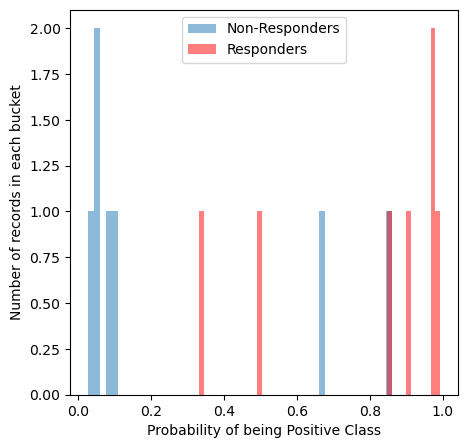

In [34]:
plt.figure(figsize=(5, 5))
plt.hist(prediction3[y_test==0], label='Non-Responders', bins = 50, alpha = 0.5)
plt.hist(prediction3[y_test==1], label='Responders', alpha=0.5, color='r', bins = 50)
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [35]:
df_xg = X_test.copy()
df_xg.loc[test_index, 'test_proba'] = prediction3
df_xg.loc[test_index, 'target'] = y_test
df3 = pd.concat([X_train, df_xg], sort=False).sort_index()
df3

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,1.390409,-0.182141,-0.811786,-0.765147,0.029913,-0.612727,0.124319,-0.552508,-0.530870,0.775370,...,-0.461933,-1.094357,0.653418,-1.234583,-0.509826,0.241904,-0.762527,1.115589,NaN,NaN
1,-0.321756,0.543561,-0.455019,-0.117538,0.572570,-0.319685,-1.133246,-1.130814,-1.177038,1.330105,...,-1.207082,0.049877,-0.936599,-1.094391,-1.158803,-2.154093,-1.588911,0.735736,NaN,NaN
2,0.881798,0.865537,-1.110763,-0.393559,0.517477,-0.730662,0.630355,0.551579,0.506838,-0.578824,...,-0.014144,-0.956000,-0.226063,-1.120271,-0.376728,-0.605035,-0.654898,-0.237836,NaN,NaN
3,-1.459050,-1.420171,0.899141,0.918588,1.105902,-0.504669,0.212440,1.522195,1.615133,-0.693285,...,-0.188425,-0.241901,0.209203,0.194145,-0.461493,-0.874633,0.433793,-0.835934,NaN,NaN
4,-1.483121,-0.057328,-0.468390,0.384379,-1.429830,-0.726266,-0.830185,-0.284303,-0.639492,-0.833595,...,-1.296961,0.298429,-1.591355,1.115319,-2.026658,-0.716160,-1.140054,-0.085691,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,0.738681,0.946810,0.130910,-0.222658,1.081287,1.048804,1.023083,0.623967,0.791437,-0.430964,...,0.483690,-0.536175,1.188293,1.131270,1.184831,0.968577,0.847409,0.232832,NaN,NaN
62,-0.517996,-0.301751,-0.733016,-0.450204,-0.084127,-0.639893,-0.540391,0.111873,0.128355,0.014643,...,0.696999,0.141135,-0.038386,-0.739822,0.018008,0.219243,0.237295,-0.438200,NaN,NaN
63,-0.183622,0.528172,0.659662,-0.122240,1.769567,-0.105774,0.957036,1.882152,1.685052,0.040208,...,2.142045,1.286565,2.231737,0.044786,1.959843,1.952841,2.449337,0.584694,NaN,NaN
64,1.470084,-1.698338,-1.200183,-0.875006,0.117897,-1.161587,0.102741,0.368464,0.554505,-1.220502,...,-0.113336,-1.017742,-0.418034,-1.082946,-0.419362,-0.168677,-0.549625,0.767915,NaN,NaN


In [36]:
df3_main = df3.iloc[:51, ]
df3_main = df3_main.loc[(df3_main['test_proba'] > max(prediction3[y_test == 0]))]
df3_main

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
5,-0.166569,-0.057328,-0.644330,-0.105402,-0.097356,-0.392880,1.042890,0.655144,0.326785,1.798392,...,-0.482378,0.528542,-0.040868,0.665786,-1.432993,0.984393,0.468556,-1.101977,0.973885,1.0
18,-0.795711,-1.643829,0.073519,-0.204115,-1.537046,-0.600807,0.067720,-1.012896,-1.077739,-1.026584,...,-0.548364,0.117033,-0.050766,0.950393,-0.232215,-0.448846,-0.933415,1.315181,0.993075,1.0
33,-0.973603,-0.057328,-0.536234,-0.366522,-1.725442,-0.362875,-0.664340,-0.668680,-0.799511,0.362864,...,-1.074829,2.050185,-2.066443,2.517478,-0.944616,-0.138554,-1.086578,-1.133314,0.909321,1.0
40,-0.611244,-0.493387,1.808447,-0.167118,-2.023160,-0.753305,0.900343,-1.130752,-1.196284,0.037497,...,-1.004834,0.104886,-1.378545,-0.216072,-2.128940,-1.059117,-1.702028,0.683255,0.977051,1.0


In [37]:
common_list = []
common_list.extend(list(df1_main.index.values))
common_list.extend(list(df2_main.index.values))
common_list.extend(list(df3_main.index.values))

In [38]:
cl = set(common_list)
cl

{5, 14, 18, 22, 33, 40}

In [39]:
df1_total = df1.loc[:51, ]
df1_total = df1_total.loc[(df1_total['target'] == 1.0)]
df1_total

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
5,-0.166569,-0.057328,-0.644330,-0.105402,-0.097356,-0.392880,1.042890,0.655144,0.326785,1.798392,...,-0.482378,0.528542,-0.040868,0.665786,-1.432993,0.984393,0.468556,-1.101977,0.774667,1.0
14,0.394437,-0.233167,1.135710,0.521580,-0.865127,1.140121,0.550898,-0.924736,-1.131072,-1.864461,...,-0.122292,0.938718,1.079153,0.753959,0.728065,0.295976,0.554439,0.208461,0.597733,1.0
18,-0.795711,-1.643829,0.073519,-0.204115,-1.537046,-0.600807,0.067720,-1.012896,-1.077739,-1.026584,...,-0.548364,0.117033,-0.050766,0.950393,-0.232215,-0.448846,-0.933415,1.315181,0.932533,1.0
22,0.297479,-0.057328,2.516632,-0.677490,-0.220492,0.212167,0.833552,0.577989,0.422283,-1.348397,...,-0.136640,-0.209043,-0.042316,2.588076,0.284885,0.157649,0.399095,0.972353,0.755200,1.0
26,1.766482,1.043637,-0.175545,0.091980,0.550484,0.140839,0.547121,-0.162624,-0.405977,1.964665,...,0.207431,-0.834662,0.039989,-0.467819,0.882631,0.404868,-0.006921,-0.911463,0.472533,1.0
33,-0.973603,-0.057328,-0.536234,-0.366522,-1.725442,-0.362875,-0.664340,-0.668680,-0.799511,0.362864,...,-1.074829,2.050185,-2.066443,2.517478,-0.944616,-0.138554,-1.086578,-1.133314,0.876667,1.0
40,-0.611244,-0.493387,1.808447,-0.167118,-2.023160,-0.753305,0.900343,-1.130752,-1.196284,0.037497,...,-1.004834,0.104886,-1.378545,-0.216072,-2.128940,-1.059117,-1.702028,0.683255,0.965467,1.0


In [40]:
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\ModelRunNTimes\\outputs\\master_list_metabolomics.txt', 'a+') as f:
    for i in cl:
        f.write(f'{i}\n')

In [41]:
l = []
l.extend(df1_total.index.values)
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\ModelRunNTimes\\outputs\\total_metabolomics.txt', 'a+') as f:
    for i in l:
        f.write(f'{i}\n')